In [1]:
!pip3 install torch

In [2]:
import torch
import torchaudio

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [3]:
pip install librosa==0.9.2

Note: you may need to restart the kernel to use updated packages.


In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
def get_all_wavs(path):
    wavs = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                wavs.append(os.path.join(root, file))
    return wavs


In [85]:
path_c='/Users/shutingxu/Downloads/illness_classify/sounds'

path_r='/Users/shutingxu/Downloads/illness_classify/respiratory'

In [86]:
c_list=get_all_wavs(path_c)
r_list=get_all_wavs(path_r)

In [87]:
def get_label(path):
    return int(path.split('/')[-2])

In [88]:
wav1, sr1 = torchaudio.load(c_list[0])
#resample to 16k
resampler = torchaudio.transforms.Resample(sr1, 16000)
wav1 = resampler(wav1)
wav1.shape

torch.Size([1, 38164])

In [89]:
wav2,sr2=torchaudio.load(r_list[0])
wav2.shape

torch.Size([1, 120000])

In [90]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  #im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [91]:
def spectrogram_r(wav):
    spec = librosa.feature.melspectrogram(wav, sr=4000, n_fft=400, hop_length=160, n_mels=128)
    return spec

def spectrogram_c(wav):
    spec = librosa.feature.melspectrogram(wav, sr=16000, n_fft=400, hop_length=160, n_mels=128)
    return spec

In [92]:
spec1=spectrogram_c(wav1[0].numpy())
spec2=spectrogram_r(wav1[0].numpy())

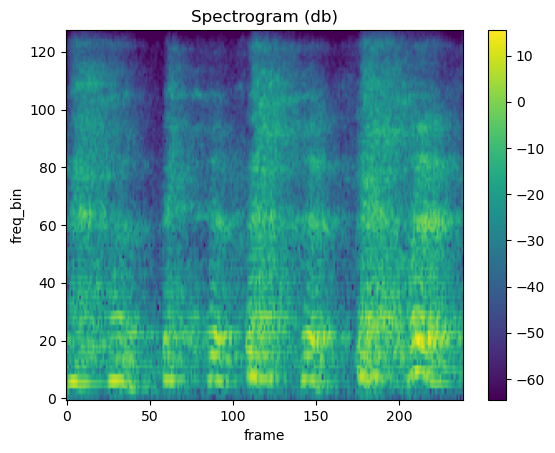

In [93]:
plot_spectrogram(spec1)

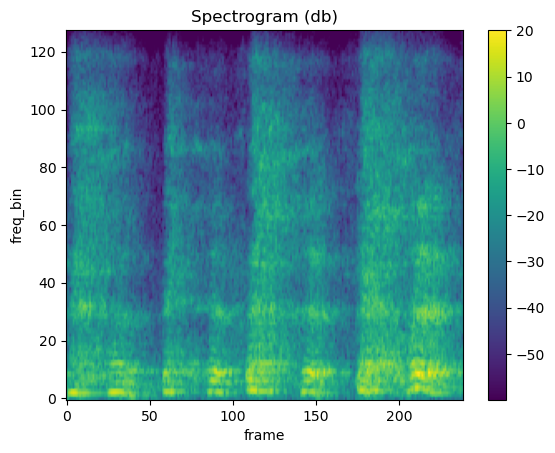

In [94]:
plot_spectrogram(spec2)

In [95]:
spec1.shape

(128, 239)

In [38]:
spec2.shape

(128, 239)

In [47]:
class c_dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.wavs = get_all_wavs(path)
        self.labels = [get_label(wav) for wav in self.wavs]
    def __len__(self):
        return len(self.wavs)
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.wavs[idx])
        resampler = torchaudio.transforms.Resample(sr, 16000)
        wav = resampler(wav)
        wav = wav[0].numpy()
        wav = spectrogram_c(wav)
        #补齐或截取至128等长
        if wav.shape[1] < 128:
            wav = np.pad(wav, ((0, 0), (0, 128 - wav.shape[1])), 'constant')
        else:
            wav = wav[:, :128]
        return torch.from_numpy(wav).unsqueeze(0), self.labels[idx]

In [48]:
class r_dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.wavs = get_all_wavs(path)
        self.labels = [get_label(wav) for wav in self.wavs]
    def __len__(self):
        return len(self.wavs)
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.wavs[idx])
        wav = wav[0].numpy()
        wav = spectrogram_r(wav)
        #从中心点截取128，左右对称
        if wav.shape[1] < 128:
            wav = np.pad(wav, ((0, 0), (0, 128 - wav.shape[1])), 'constant')
        else:
            wav = wav[:, (wav.shape[1] - 128) // 2:(wav.shape[1] - 128) // 2 + 128]
        return torch.from_numpy(wav).unsqueeze(0), self.labels[idx]

In [50]:
dataset_c = c_dataset(path_c)
dataset_r = r_dataset(path_r)

In [51]:
dataset_c[0][0].shape

torch.Size([1, 128, 128])

In [52]:
dataset_c[0][1]

0

In [53]:
dataset_r[0][0].shape

torch.Size([1, 128, 128])

In [54]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

In [96]:
device=torch.device('cuda:0')

In [97]:
!conda install -c pytorch pytorch=1.2.0=py3.7_cuda92_cudnn7_1

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - pytorch==1.2.0=py3.7_cuda92_cudnn7_1

Current channels:

  - https://conda.anaconda.org/pytorch/osx-64
  - https://conda.anaconda.org/pytorch/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [99]:
pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 MB 2.2 MB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 2.1 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1
    Uninstalling torchaudio-0.13.1:
      Successfully uninstalled torchaudio-0.13.1
Note: you may need to restart the kernel to use updated packages.


In [100]:
model_c=resnet18().to(device)

AssertionError: Torch not compiled with CUDA enabled

In [66]:
!pip3 install torch==1.10.0+cu102 torchvision==0.12.1+cu102 

device(type='cuda', index=0)

In [57]:
bs=16
#seperate the dataset into train and test 0.8 and 0.2
train_size=int(0.8*len(dataset_c))
test_size=len(dataset_c)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset_c,[train_size,test_size])
train_loader=DataLoader(train_dataset,batch_size=bs,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=bs,shuffle=True)


In [51]:
optimizer=torch.optim.Adam(model_c.parameters(),lr=5e-4)
loss_fn=nn.CrossEntropyLoss()

In [43]:
def train(model, train_loader, loss_fn, optimizer):
    size = len(train_loader.dataset)
    model.train()
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 30 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(model, test_loader, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [52]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model_c, train_loader, loss_fn, optimizer)
    test(model_c, test_loader, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.777460  [    0/ 1552]
loss: 0.348315  [  480/ 1552]
loss: 0.402388  [  960/ 1552]
loss: 0.533781  [ 1440/ 1552]
Test Error: 
 Accuracy: 68.9%, Avg loss: 0.562037 

Epoch 2
-------------------------------
loss: 0.560043  [    0/ 1552]
loss: 0.290820  [  480/ 1552]
loss: 0.482806  [  960/ 1552]
loss: 0.357503  [ 1440/ 1552]
Test Error: 
 Accuracy: 70.4%, Avg loss: 0.547448 

Epoch 3
-------------------------------
loss: 0.482075  [    0/ 1552]
loss: 0.294417  [  480/ 1552]
loss: 0.400352  [  960/ 1552]
loss: 0.397295  [ 1440/ 1552]
Test Error: 
 Accuracy: 72.2%, Avg loss: 0.604171 

Epoch 4
-------------------------------
loss: 0.367527  [    0/ 1552]
loss: 0.622337  [  480/ 1552]
loss: 0.656466  [  960/ 1552]
loss: 0.403413  [ 1440/ 1552]
Test Error: 
 Accuracy: 71.7%, Avg loss: 0.587418 

Epoch 5
-------------------------------
loss: 0.377427  [    0/ 1552]
loss: 0.505616  [  480/ 1552]
loss: 0.278860  [  960/ 1552]
loss: 0.423469  [ 1440

KeyboardInterrupt: 

In [53]:
torch.save(model_c, "model_c.pth")

In [80]:
model_r=resnet18().to(device)

In [81]:
bs=8
#seperate the dataset into train and test 0.8 and 0.2
train_size=int(0.8*len(dataset_r))
test_size=len(dataset_r)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset_r,[train_size,test_size])
train_loader=DataLoader(train_dataset,batch_size=bs,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=bs,shuffle=True)

In [83]:
optimizer=torch.optim.Adam(model_r.parameters(),lr=1e-4)
loss_fn=nn.CrossEntropyLoss()

In [84]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model_r, train_loader, loss_fn, optimizer)
    test(model_r, test_loader, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.920003  [    0/  162]
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.248919 

Epoch 2
-------------------------------
loss: 0.090744  [    0/  162]
Test Error: 
 Accuracy: 73.2%, Avg loss: 0.353466 

Epoch 3
-------------------------------
loss: 0.065748  [    0/  162]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.138510 

Epoch 4
-------------------------------
loss: 0.072251  [    0/  162]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.220654 

Epoch 5
-------------------------------
loss: 0.077428  [    0/  162]


KeyboardInterrupt: 

In [85]:
torch.save(model_r, "model_r.pth")